In [1]:
!pip install kaggle
import os
os.environ['KAGGLE_USERNAME'] = 'sinthiarupa'
os.environ['KAGGLE_KEY'] = '5aa4c81436f64ca078ec6532dc5fed88'
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100%|██████████████████████████████████████| 5.20G/5.20G [03:09<00:00, 31.7MB/s]
100%|██████████████████████████████████████| 5.20G/5.20G [03:09<00:00, 29.5MB/s]


In [2]:
import os

# List the directories in the current directory
os.listdir('.')


['__notebook_source__.ipynb',
 '.virtual_documents',
 'skin-cancer-mnist-ham10000.zip']

In [3]:
import pandas as pd
import zipfile

# Extract the zip file
with zipfile.ZipFile('skin-cancer-mnist-ham10000.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Load the dataset into a DataFrame
skin_df = pd.read_csv('HAM10000_metadata.csv')


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [6]:
SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_)) #dx is fitted but not converted yet

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [7]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

In [8]:
skin_df #new column label is added with nnumeric value of dx

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,0


Data distribution

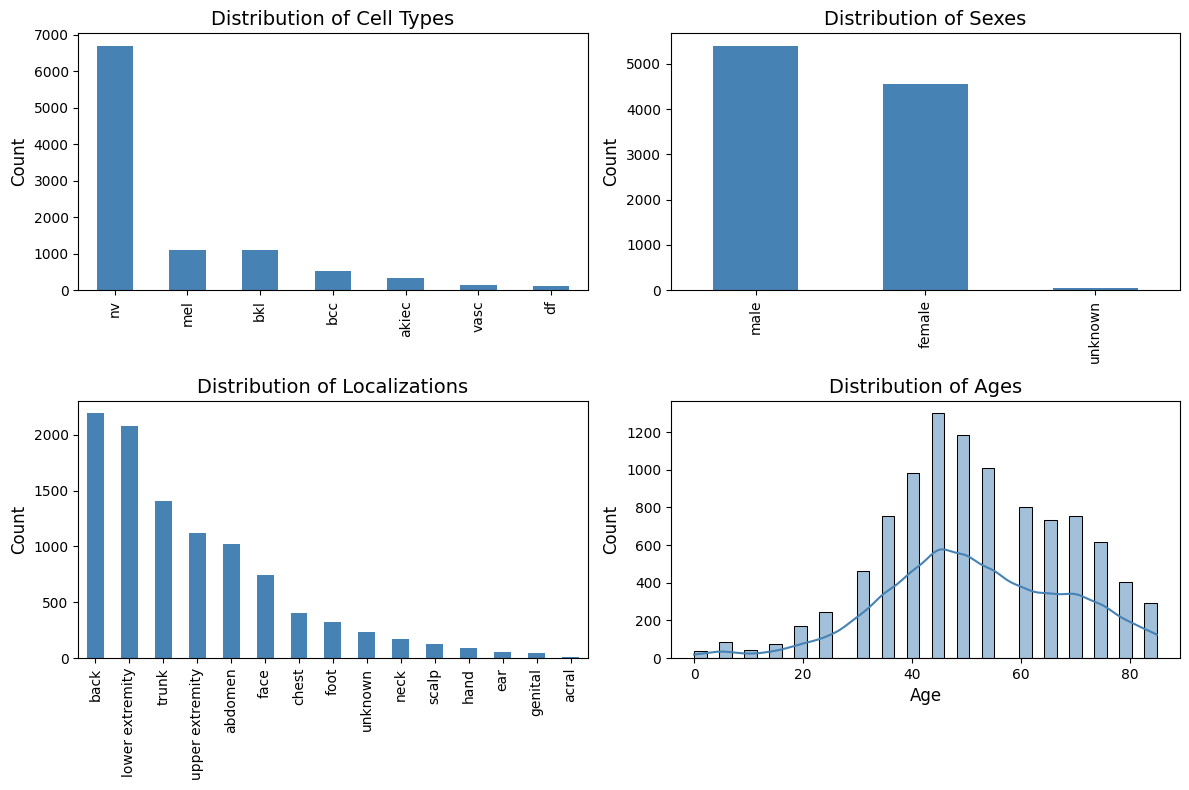

In [9]:
# Data distribution visualization
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

# Plot the distribution of cell types
skin_df['dx'].value_counts().plot(kind='bar', ax=axs[0], color='steelblue')
axs[0].set_ylabel('Count', fontsize=12)
axs[0].set_title('Distribution of Cell Types', fontsize=14)

# Plot the distribution of sexes
skin_df['sex'].value_counts().plot(kind='bar', ax=axs[1], color='steelblue')
axs[1].set_ylabel('Count', fontsize=12)
axs[1].set_title('Distribution of Sexes', fontsize=14)

# Plot the distribution of localizations
skin_df['localization'].value_counts().plot(kind='bar', ax=axs[2], color='steelblue')
axs[2].set_ylabel('Count', fontsize=12)
axs[2].set_title('Distribution of Localizations', fontsize=14)

# Plot the distribution of ages
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.histplot(data=sample_age, x='age', kde=True, color='steelblue', ax=axs[3])
axs[3].set_xlabel('Age', fontsize=12)
axs[3].set_ylabel('Count', fontsize=12)
axs[3].set_title('Distribution of Ages', fontsize=14)

plt.tight_layout()
plt.show()


Is dataset balance or not

In [10]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


checking missing values

In [11]:
skin_df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
label            0
dtype: int64

clean missing value

In [12]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
label           0
dtype: int64

check the duplicates

In [13]:

# Check for duplicates in all columns
duplicates = skin_df.duplicated()

# Count the number of duplicates
num_duplicates = duplicates.sum()

# Print the number of duplicates
print(f'There are {num_duplicates} duplicate rows in skin_df')



There are 0 duplicate rows in skin_df


In [14]:
skin_df.describe()

,age,label
count,10015.000000,10015.000000
mean,51.863828,4.182327
std,16.920252,1.458742
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,5.000000
75%,65.000000,5.000000
max,85.000000,6.000000


In [15]:
skin_df.shape

(10015, 8)

In [16]:
print(skin_df.dtypes)

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
label             int64
dtype: object


Data balancing

Using Random undersampling

In [17]:


from sklearn.utils import resample
import pandas as pd

# Count the number of samples in each class
class_counts = skin_df['dx'].value_counts()

# Set the target number of samples per class (you can adjust this as needed)
target_count = min(class_counts)

# Downsample each class to the target count
downsampled_dfs = []
for class_name in class_counts.index:
    class_df = skin_df[skin_df['dx'] == class_name]
    downsampled_df = resample(class_df, replace=False, n_samples=target_count, random_state=42)
    downsampled_dfs.append(downsampled_df)

# Concatenate the downsampled dataframes into a single balanced dataframe
skin_df_balance = pd.concat(downsampled_dfs)

# Shuffle the rows of the balanced dataframe
skin_df_balance = skin_df_balance.sample(frac=1, random_state=42)


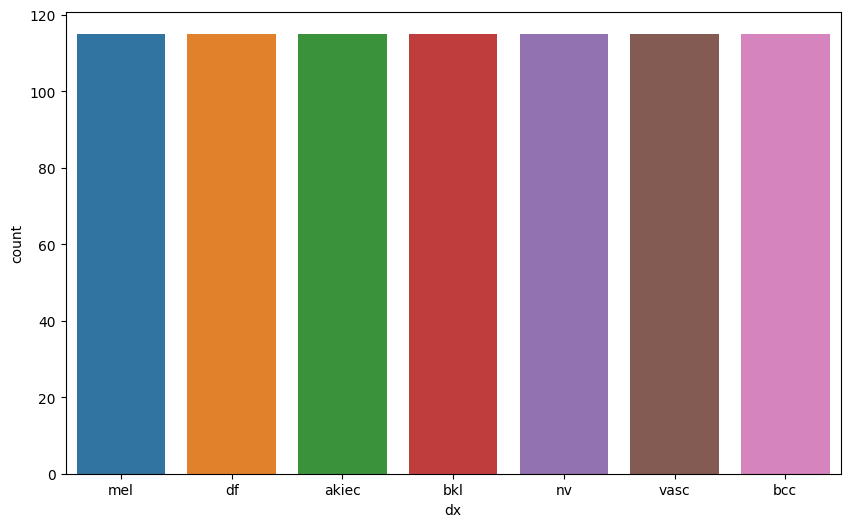

In [18]:
# Visualize the class distribution after balancing
plt.figure(figsize=(10,6))
sns.countplot(data=skin_df_balance, x='dx')
plt.show()

In [19]:
class_counts = skin_df_balance['dx'].value_counts()
print(class_counts)

mel      115
df       115
akiec    115
bkl      115
nv       115
vasc     115
bcc      115
Name: dx, dtype: int64


In [22]:
print(skin_df_balance.columns)

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'label'],
      dtype='object')


In [23]:

# Define the directories containing the image data
dirs = ['HAM10000_images_part_1', 'HAM10000_images_part_2', 'ham10000_images_part_1', 'ham10000_images_part_2']

# Create an empty dictionary to store the image paths
image_path = {}

# Loop through each directory and get the image paths
for d in dirs:
    for subdir, _, files in os.walk(d):
        for f in files:
            if f.endswith('.jpg'):
                image_path[f[:-4]] = os.path.join(subdir, f)
                
# # Print the image paths
# print(image_path)


In [24]:
skin_df_balance['path'] = skin_df_balance['image_id'].map(image_path.get)


In [25]:
# #Use the path to read images.
# skin_df_balance['image'] = skin_df_balance['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
# # skin_df_balance['image'] = skin_df_balance['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))




from concurrent.futures import ThreadPoolExecutor
from PIL import Image

# Define a function to resize a single image
def resize_image(img_path, size):
    img = Image.open(img_path)
    img = img.resize(size)
    return np.asarray(img)

# Define the image size
image_size = (32, 32)

# Get the list of image files in the DataFrame
img_files = skin_df_balance['path'].tolist()

# Resize the images using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    resized_images = list(executor.map(lambda x: resize_image(x, image_size), img_files))

# Add the resized images to the DataFrame
skin_df_balance['image'] = resized_images


In [26]:
skin_df_balance

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
1965,HAM_0001444,ISIC_0024688,mel,histo,40.0,female,lower extremity,4,ham10000_images_part_1/ISIC_0024688.jpg,"[[[203, 161, 185], [204, 163, 192], [205, 164,..."
1139,HAM_0003290,ISIC_0030757,df,histo,80.0,male,upper extremity,3,ham10000_images_part_2/ISIC_0030757.jpg,"[[[206, 173, 175], [211, 177, 183], [214, 178,..."
2261,HAM_0002131,ISIC_0030901,mel,histo,55.0,male,upper extremity,4,ham10000_images_part_2/ISIC_0030901.jpg,"[[[166, 137, 152], [169, 141, 161], [172, 142,..."
9747,HAM_0005766,ISIC_0031738,akiec,histo,85.0,male,upper extremity,0,ham10000_images_part_2/ISIC_0031738.jpg,"[[[195, 142, 168], [225, 182, 213], [225, 192,..."
9795,HAM_0005505,ISIC_0026522,akiec,histo,50.0,male,upper extremity,0,ham10000_images_part_1/ISIC_0026522.jpg,"[[[137, 99, 108], [148, 114, 127], [156, 124, ..."
...,...,...,...,...,...,...,...,...,...,...
4421,HAM_0001535,ISIC_0026653,nv,follow_up,45.0,male,trunk,5,ham10000_images_part_1/ISIC_0026653.jpg,"[[[229, 137, 167], [231, 141, 170], [228, 133,..."
5977,HAM_0007271,ISIC_0027862,nv,follow_up,30.0,male,abdomen,5,ham10000_images_part_1/ISIC_0027862.jpg,"[[[243, 161, 173], [245, 161, 173], [244, 157,..."
1035,HAM_0002034,ISIC_0027954,bkl,consensus,5.0,male,abdomen,2,ham10000_images_part_1/ISIC_0027954.jpg,"[[[219, 142, 159], [219, 138, 159], [219, 136,..."
2555,HAM_0005530,ISIC_0029899,bcc,histo,50.0,female,chest,1,ham10000_images_part_2/ISIC_0029899.jpg,"[[[173, 130, 126], [176, 136, 139], [182, 149,..."


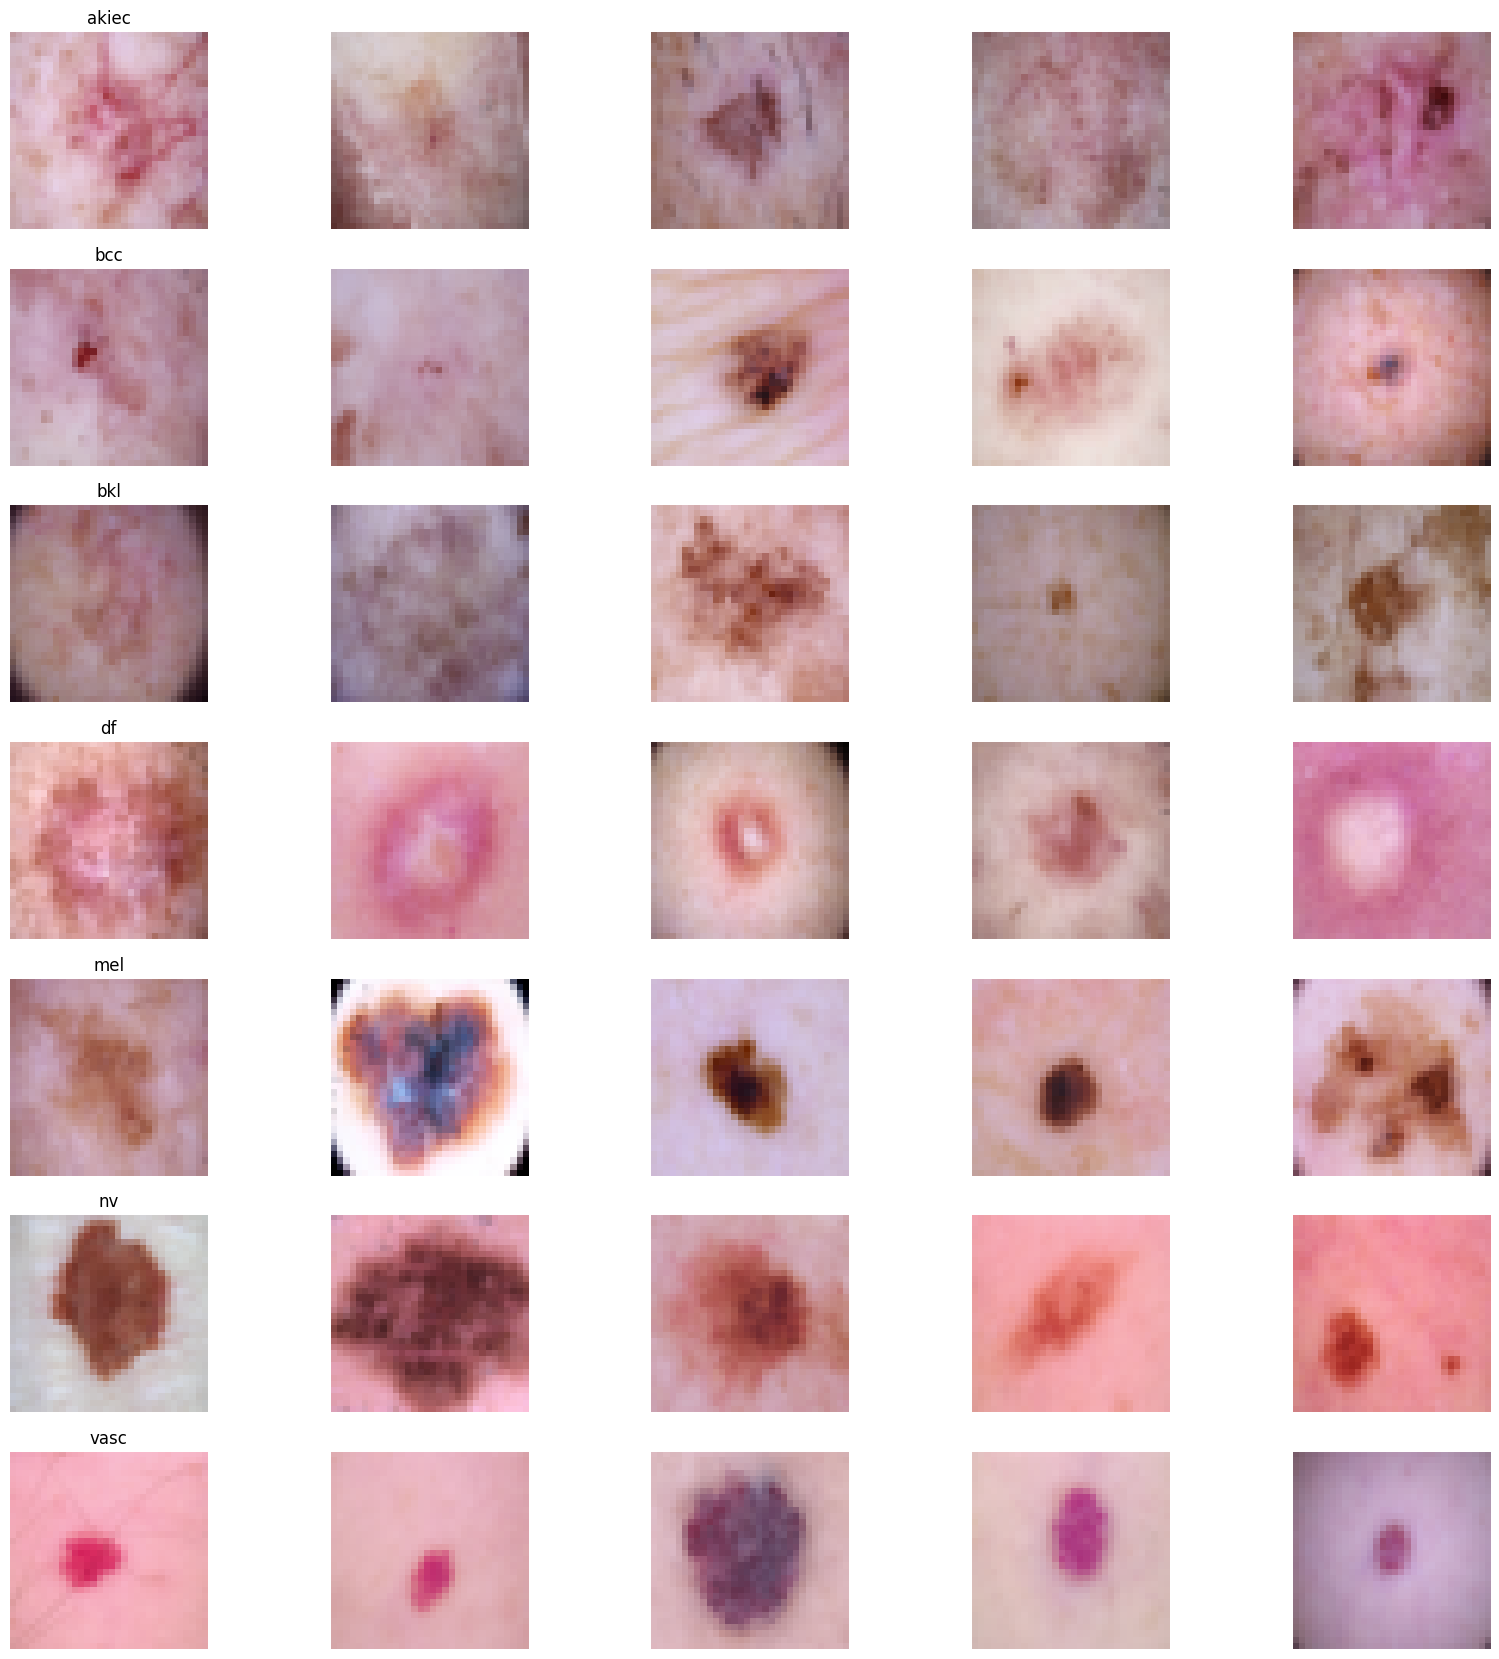

In [ ]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balance.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
# Checking the image size distribution
skin_df_balance['image'].map(lambda x: x.shape).value_counts()

In [ ]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balance['image'].tolist()) #taking image column in x and turn it into a list
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balance['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem


Train Test Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=1234)

Splitting training and validation split

In [ ]:


# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, Y_cat, test_size=0.2, random_state=42)


In [ ]:
# Shape of the training data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# Shape of the validation data
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

# Shape of the test data
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)


Model Building

Simple cnn for fun huh

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
21/21 [==============================] - 2s 52ms/step - loss: 1.9560 - accuracy: 0.1506 - val_loss: 1.9427 - val_accuracy: 0.1366
Epoch 2/10
21/21 [==============================] - 1s 31ms/step - loss: 1.9427 - accuracy: 0.1553 - val_loss: 1.9361 - val_accuracy: 0.1988
Epoch 3/10
21/21 [==============================] - 1s 30ms/step - loss: 1.8888 - accuracy: 0.2329 - val_loss: 1.8735 - val_accuracy: 0.2174
Epoch 4/10
21/21 [==============================] - 1s 30ms/step - loss: 1.8048 - accuracy: 0.2686 - val_loss: 1.8464 - val_accuracy: 0.2112
Epoch 5/10
21/21 [==============================] - 1s 30ms/step - loss: 1.7664 - accuracy: 0.2764 - val_loss: 2.0292 - val_accuracy: 0.1677
Epoch 6/10
21/21 [==============================] - 1s 33ms/step - loss: 1.7705 - accuracy: 0.2717 - val_loss: 1.8019 - val_accuracy: 0.2298
Epoch 7/10
21/21 [==============================] - 1s 31ms/step - loss: 1.7139 - accuracy: 0.2795 - val_loss: 1.7667 - val_accuracy: 0.2733
Epoch 8/10
21

In [36]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)

6/6 [==============================] - 0s 10ms/step - loss: 1.4939 - accuracy: 0.3665


In [37]:
# Print the test accuracy
print('Test accuracy:', test_acc)

Test accuracy: 0.3664596378803253


In [38]:
# Predict the labels of the test set
y_pred = model.predict(x_test)
# Convert the predicted probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

# Convert the true labels to class labels
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)

6/6 [==============================] - 0s 9ms/step
[[ 0 16  0  0  2  0  2]
 [ 0 19  0  0  2  0  3]
 [ 1 11  0  0  3  1  1]
 [ 2 19  1  0  1  0  0]
 [ 2  6  2  0 11  0  7]
 [ 0  2  1  0 10 10  0]
 [ 0  5  0  0  2  0 19]]


6/6 [==============================] - 0s 8ms/step


<AxesSubplot: >

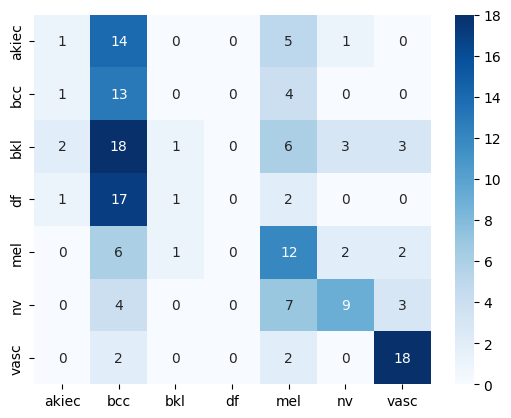

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the true labels for the validation set
y_true = np.argmax(y_val, axis=1)

# Get the predicted labels for the validation set
y_pred = np.argmax(model.predict(X_val), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], yticklabels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])


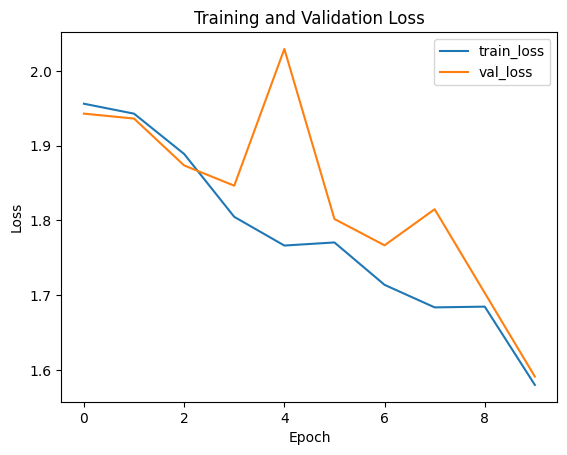

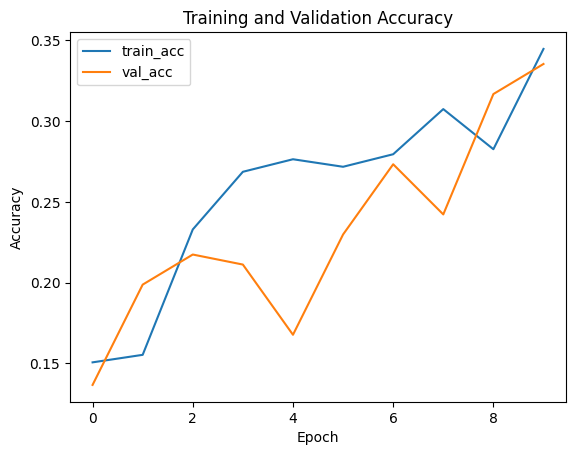

In [40]:
import matplotlib.pyplot as plt

# plot the training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Lets Try Vison=> Just no reason huh**

In [41]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])


In [42]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [43]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val))

Epoch 1/10
21/21 [==============================] - 1s 32ms/step - loss: 1.9777 - accuracy: 0.1801 - val_loss: 1.8953 - val_accuracy: 0.2298
Epoch 2/10
21/21 [==============================] - 0s 21ms/step - loss: 1.8370 - accuracy: 0.3090 - val_loss: 1.8792 - val_accuracy: 0.1739
Epoch 3/10
21/21 [==============================] - 0s 21ms/step - loss: 1.7820 - accuracy: 0.3245 - val_loss: 1.7927 - val_accuracy: 0.2919
Epoch 4/10
21/21 [==============================] - 0s 21ms/step - loss: 1.6614 - accuracy: 0.3711 - val_loss: 1.6923 - val_accuracy: 0.3292
Epoch 5/10
21/21 [==============================] - 0s 20ms/step - loss: 1.6247 - accuracy: 0.3835 - val_loss: 1.6698 - val_accuracy: 0.3292
Epoch 6/10
21/21 [==============================] - 0s 22ms/step - loss: 1.5076 - accuracy: 0.4301 - val_loss: 1.6092 - val_accuracy: 0.3851
Epoch 7/10
21/21 [==============================] - 0s 21ms/step - loss: 1.3954 - accuracy: 0.4907 - val_loss: 1.5347 - val_accuracy: 0.4161
Epoch 8/10
21

In [44]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
# Print test accuracy
print('Test accuracy:', test_acc)


6/6 [==============================] - 0s 7ms/step - loss: 1.1730 - accuracy: 0.5714
Test accuracy: 0.5714285969734192


In [45]:
# Make predictions
y_pred = model.predict(x_test)

# Create confusion matrix
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))


6/6 [==============================] - 0s 6ms/step


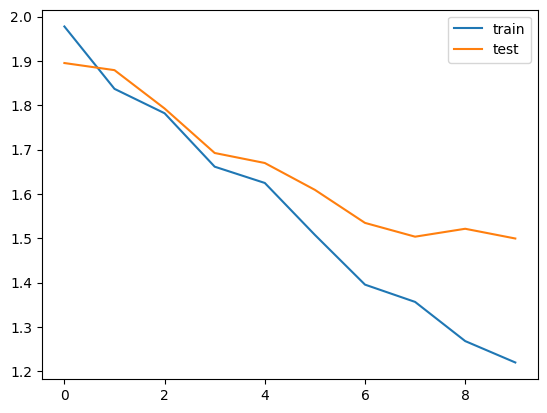

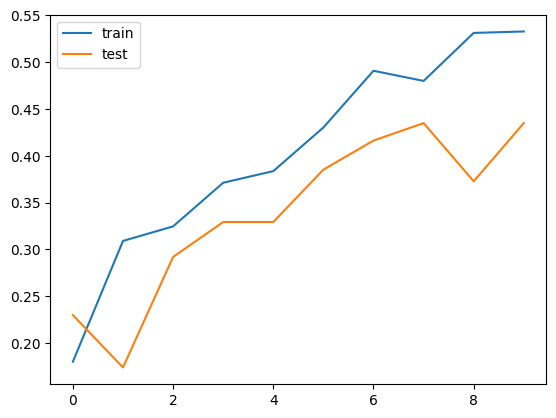

In [46]:
# Plot train and test loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Plot train and test accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [47]:
# Print confusion matrix
print('Confusion matrix:')
print(conf_mat)

Confusion matrix:
[[ 8  6  0  3  0  1  2]
 [ 4 15  0  1  0  1  3]
 [ 1  5  0  3  6  2  0]
 [ 5  3  0 11  3  0  1]
 [ 2  0  0  3 19  2  2]
 [ 3  0  0  0  2 16  2]
 [ 1  1  0  0  1  0 23]]


6/6 [==============================] - 0s 6ms/step


<AxesSubplot: >

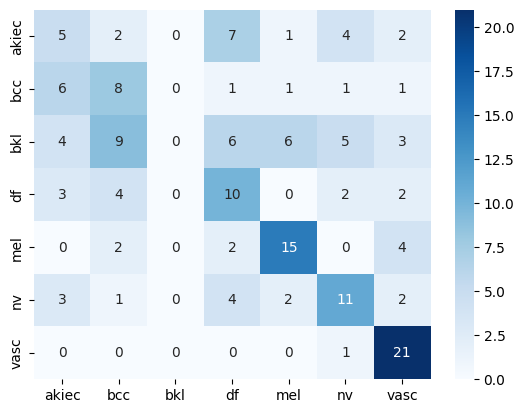

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the true labels for the validation set
y_true = np.argmax(y_val, axis=1)

# Get the predicted labels for the validation set
y_pred = np.argmax(model.predict(X_val), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], yticklabels=['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
